# Linux Commits Zone Analysis

This notebook analyzes Linux kernel commits from a JSONL file, categorizing changes by root directory zones.

## Import Required Libraries

Import necessary libraries for data processing and visualization.

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load JSONL Data

Read the commit data from the JSONL file.

In [4]:
# Load the JSONL file
commits = []
with open('../data/1000-linux-commits.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        commits.append(json.loads(line))

print(f"Loaded {len(commits)} commits")
print(f"\nSample commit structure:")
print(json.dumps(commits[0], indent=2)[:500] + "...")

Loaded 1000 commits

Sample commit structure:
{
  "backend_name": "Git",
  "backend_version": "0.13.0",
  "category": "commit",
  "classified_fields_filtered": null,
  "data": {
    "Author": "Greg Kroah-Hartman <gregkh@linuxfoundation.org>",
    "AuthorDate": "Thu Jan 6 10:54:01 2022 +0100",
    "Commit": "Heiko Carstens <hca@linux.ibm.com>",
    "CommitDate": "Sat Jan 8 17:44:05 2022 +0100",
    "Signed-off-by": [
      "Greg Kroah-Hartman <gregkh@linuxfoundation.org>",
      "Heiko Carstens <hca@linux.ibm.com>"
    ],
    "commit": "0704...


## Extract Zones from File Paths

Create a function to extract the root directory (zone) from file paths.

In [5]:
def extract_zone(file_path):
    """
    Extract the root directory zone from a file path.
    
    Args:
        file_path (str): The file path to process
        
    Returns:
        str: The zone (first directory after root, or 'root' for files in root directory)
    """
    if '/' in file_path:
        # Extract the first directory after root
        zone = file_path.split('/')[0]
    else:
        # File is in the root directory
        zone = 'root'
    
    return zone

## Add Zone Information to Commits

Process each commit to extract all unique zones affected.

In [6]:
# Add zone information to each commit
for commit in commits:
    # Get the list of modified files
    files = commit.get('data', {}).get('files', [])
    
    # Extract zones from all files
    zones = set()
    for file_info in files:
        file_path = file_info.get('file', '')
        if file_path:
            zone = extract_zone(file_path)
            zones.add(zone)
    
    # Add the zone field (as a list for consistency)
    commit['zone'] = sorted(list(zones))

# Display sample results
print("Sample commits with zone information:")
for i in range(min(3, len(commits))):
    files_list = [f.get('file', '') for f in commits[i]['data']['files']]
    print(f"\nCommit {i+1}:")
    print(f"  Files: {files_list[:3]}{'...' if len(files_list) > 3 else ''}")
    print(f"  Zones: {commits[i]['zone']}")

Sample commits with zone information:

Commit 1:
  Files: ['drivers/s390/block/dasd_devmap.c']
  Zones: ['drivers']

Commit 2:
  Files: ['arch/x86/include/asm/page_64.h', 'arch/x86/include/asm/pgtable.h', 'arch/x86/include/asm/realmode.h']...
  Zones: ['arch']

Commit 3:
  Files: ['arch/x86/mm/init_64.c', 'include/linux/bootmem_info.h', 'mm/bootmem_info.c']...
  Zones: ['arch', 'include', 'mm']


## Count Affected Zones per Commit

Add a field indicating the number of different zones affected in each commit.

In [7]:
# Add the number of zones affected
for commit in commits:
    commit['num_zones'] = len(commit['zone'])

# Create a DataFrame for easier analysis
df = pd.DataFrame([
    {
        'commit_hash': commit['data'].get('commit', 'unknown'),
        'zone': commit['zone'],
        'num_zones': commit['num_zones']
    }
    for commit in commits
])

print(f"Total commits: {len(df)}")
print(f"\nDistribution of number of zones per commit:")
print(df['num_zones'].value_counts().sort_index())
print(f"\nSummary statistics:")
print(df['num_zones'].describe())

Total commits: 1000

Distribution of number of zones per commit:
num_zones
0       1
1     877
2      85
3      17
4      14
5       3
7       1
21      1
23      1
Name: count, dtype: int64

Summary statistics:
count    1000.000000
mean        1.220000
std         1.095811
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        23.000000
Name: num_zones, dtype: float64


## Analyze Commits by Zone

Count how many commits affect each zone.

In [8]:
# Count commits per zone (a commit can affect multiple zones)
zone_counter = Counter()

for commit in commits:
    for zone in commit['zone']:
        zone_counter[zone] += 1

# Create a DataFrame for the zone statistics
zone_df = pd.DataFrame([
    {'zone': zone, 'commit_count': count}
    for zone, count in zone_counter.most_common()
])

print(f"Total unique zones: {len(zone_df)}")
print(f"\nTop 15 zones by number of commits:")
print(zone_df.head(15).to_string(index=False))

Total unique zones: 24

Top 15 zones by number of commits:
         zone  commit_count
      drivers           533
         arch           130
      include           104
Documentation            94
           fs            63
        tools            54
          net            53
        sound            47
       kernel            29
           mm            27
         root            27
          lib             9
        block             8
      scripts             7
     security             7


## Visualize Commits Distribution by Zone

Generate visualizations showing the distribution of commits across zones.

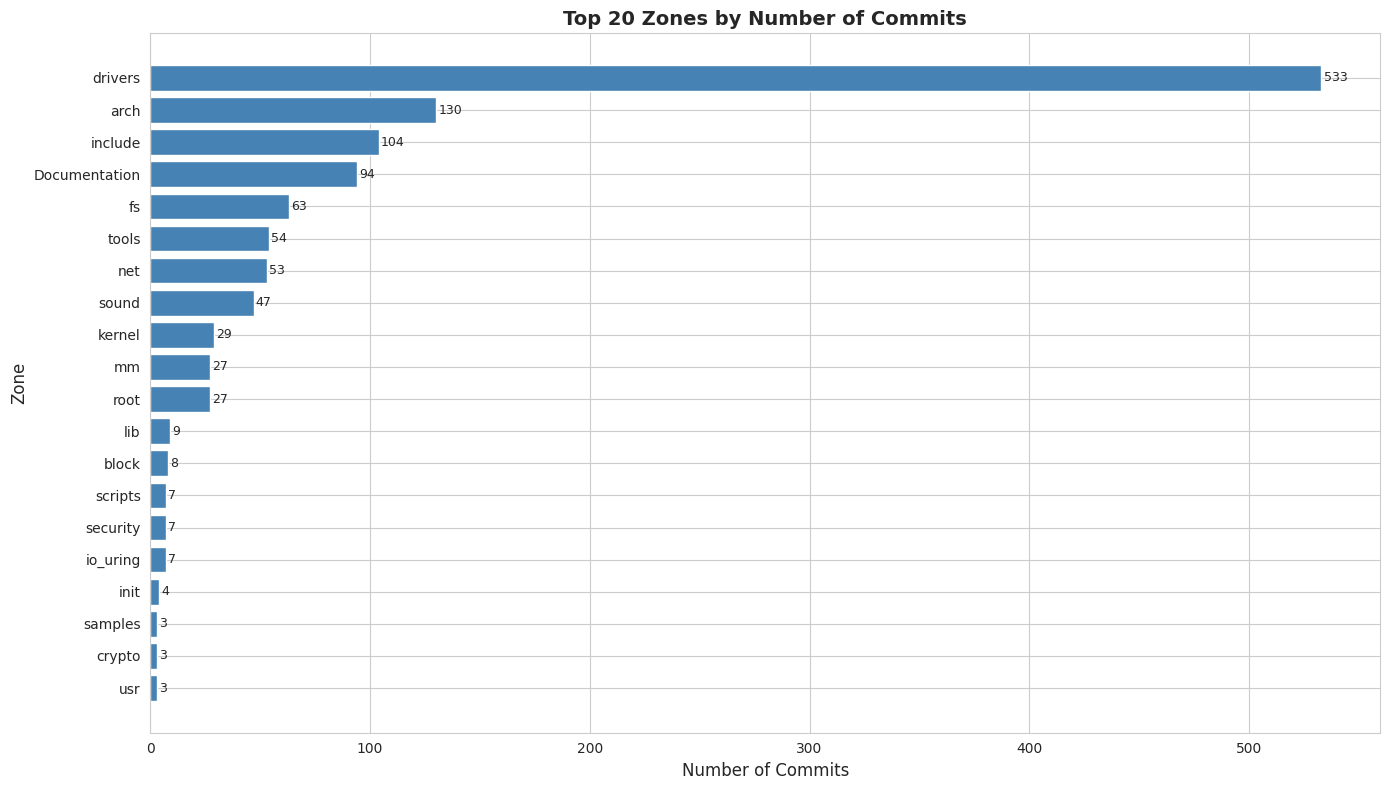

In [9]:
# Plot the top 20 zones by commit count
top_n = 20
top_zones = zone_df.head(top_n)

plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(top_zones)), top_zones['commit_count'], color='steelblue')
plt.yticks(range(len(top_zones)), top_zones['zone'])
plt.xlabel('Number of Commits', fontsize=12)
plt.ylabel('Zone', fontsize=12)
plt.title(f'Top {top_n} Zones by Number of Commits', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest count at the top

# Add value labels on the bars
for i, (idx, row) in enumerate(top_zones.iterrows()):
    plt.text(row['commit_count'] + 1, i, str(row['commit_count']), 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

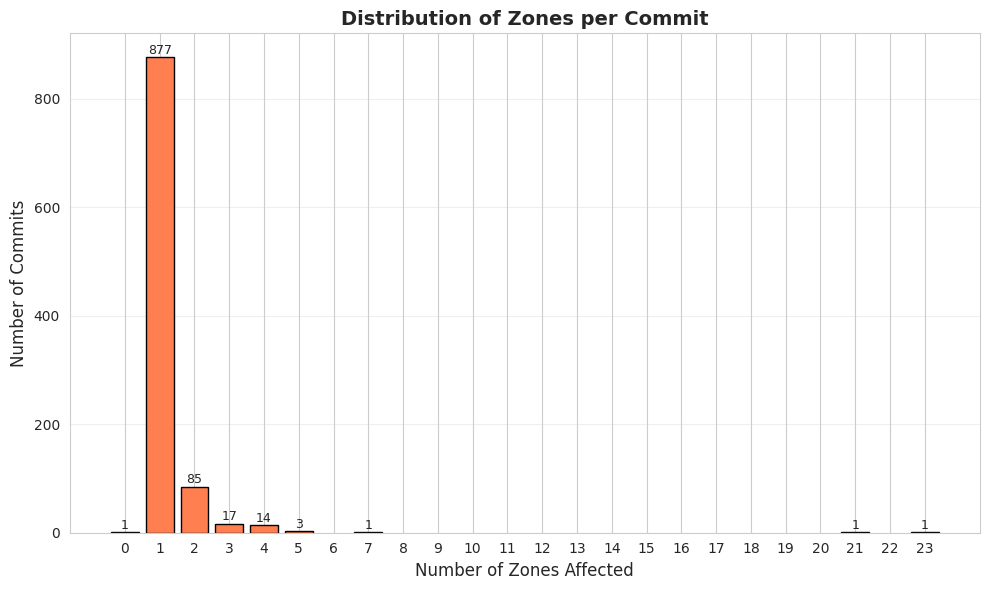

In [10]:
# Additional visualization: Distribution of number of zones per commit
plt.figure(figsize=(10, 6))
num_zones_counts = df['num_zones'].value_counts().sort_index()
plt.bar(num_zones_counts.index, num_zones_counts.values, color='coral', edgecolor='black')
plt.xlabel('Number of Zones Affected', fontsize=12)
plt.ylabel('Number of Commits', fontsize=12)
plt.title('Distribution of Zones per Commit', fontsize=14, fontweight='bold')
plt.xticks(range(int(num_zones_counts.index.min()), int(num_zones_counts.index.max()) + 1))

# Add value labels on the bars
for x, y in zip(num_zones_counts.index, num_zones_counts.values):
    plt.text(x, y + 0.5, str(y), ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Save Enhanced Data

Save the commits with the new zone information to a new file (optional).

In [11]:
# Optionally save the enhanced data
output_path = '../data/1000-linux-commits-with-zones.jsonl'

with open(output_path, 'w', encoding='utf-8') as f:
    for commit in commits:
        f.write(json.dumps(commit) + '\n')

print(f"Enhanced data saved to: {output_path}")

Enhanced data saved to: ../data/1000-linux-commits-with-zones.jsonl


## Analysis: Merge Commits vs Non-Merge Commits

Investigate if commits with multiple zones are merge commits (commits with more than one parent).

In [12]:
# Identify merge commits (commits with more than one parent)
for commit in commits:
    parents = commit.get('data', {}).get('parents', [])
    commit['is_merge'] = len(parents) > 1
    commit['num_parents'] = len(parents)

# Create DataFrame with merge information
df_merge_analysis = pd.DataFrame([
    {
        'commit_hash': commit['data'].get('commit', 'unknown'),
        'is_merge': commit['is_merge'],
        'num_parents': commit['num_parents'],
        'num_zones': commit['num_zones'],
        'zones': commit['zone']
    }
    for commit in commits
])

print(f"Total commits: {len(df_merge_analysis)}")
print(f"Merge commits: {df_merge_analysis['is_merge'].sum()}")
print(f"Non-merge commits: {(~df_merge_analysis['is_merge']).sum()}")
print(f"\nMerge commits distribution by number of zones:")
print(df_merge_analysis[df_merge_analysis['is_merge']]['num_zones'].value_counts().sort_index())

Total commits: 1000
Merge commits: 89
Non-merge commits: 911

Merge commits distribution by number of zones:
num_zones
0      1
1     42
2     25
3      7
4     10
5      2
21     1
23     1
Name: count, dtype: int64


## Zone Analysis for Non-Merge Commits Only

Calculate zone statistics excluding merge commits.

In [13]:
# Filter non-merge commits
non_merge_commits = [c for c in commits if not c['is_merge']]

print(f"Non-merge commits: {len(non_merge_commits)}")

# Count commits per zone for non-merge commits only
zone_counter_non_merge = Counter()

for commit in non_merge_commits:
    for zone in commit['zone']:
        zone_counter_non_merge[zone] += 1

# Create a DataFrame for the zone statistics (non-merge only)
zone_df_non_merge = pd.DataFrame([
    {'zone': zone, 'commit_count': count}
    for zone, count in zone_counter_non_merge.most_common()
])

print(f"\nTotal unique zones (non-merge): {len(zone_df_non_merge)}")
print(f"\nTop 15 zones by number of non-merge commits:")
print(zone_df_non_merge.head(15).to_string(index=False))

# Distribution of zones per non-merge commit
non_merge_zone_counts = pd.Series([c['num_zones'] for c in non_merge_commits]).value_counts().sort_index()
print(f"\nDistribution of number of zones per non-merge commit:")
print(non_merge_zone_counts)

Non-merge commits: 911

Total unique zones (non-merge): 21

Top 15 zones by number of non-merge commits:
         zone  commit_count
      drivers           484
         arch           106
Documentation            75
      include            74
           fs            53
        tools            44
          net            41
        sound            38
           mm            24
       kernel            22
         root            20
     io_uring             7
      scripts             5
        block             5
          lib             5

Distribution of number of zones per non-merge commit:
1    835
2     60
3     10
4      4
5      1
7      1
Name: count, dtype: int64


## Visualizations: Non-Merge Commits

Compare zone distributions between all commits and non-merge commits only.

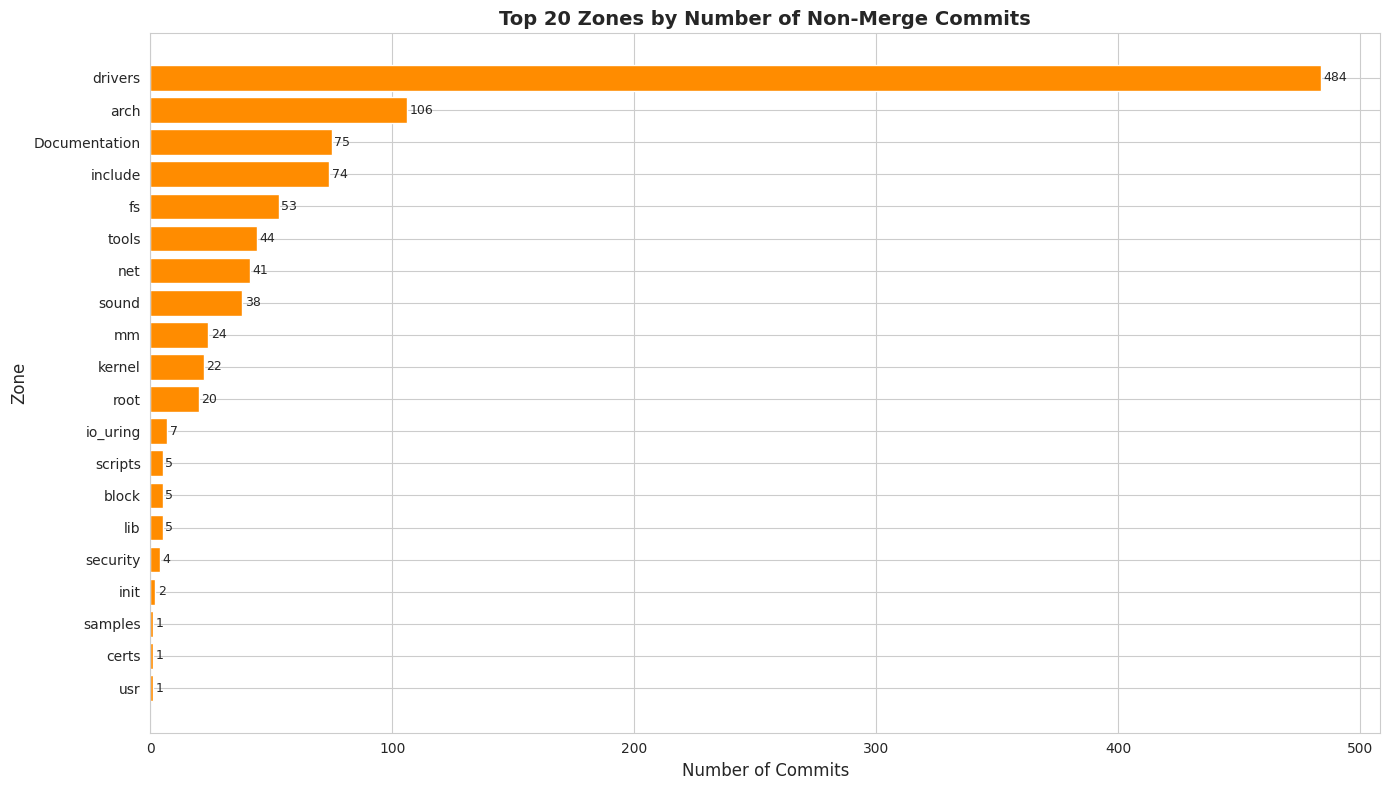

In [14]:
# Plot the top 20 zones by commit count (non-merge commits only)
top_n = 20
top_zones_non_merge = zone_df_non_merge.head(top_n)

plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(top_zones_non_merge)), top_zones_non_merge['commit_count'], color='darkorange')
plt.yticks(range(len(top_zones_non_merge)), top_zones_non_merge['zone'])
plt.xlabel('Number of Commits', fontsize=12)
plt.ylabel('Zone', fontsize=12)
plt.title(f'Top {top_n} Zones by Number of Non-Merge Commits', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest count at the top

# Add value labels on the bars
for i, (idx, row) in enumerate(top_zones_non_merge.iterrows()):
    plt.text(row['commit_count'] + 1, i, str(row['commit_count']), 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

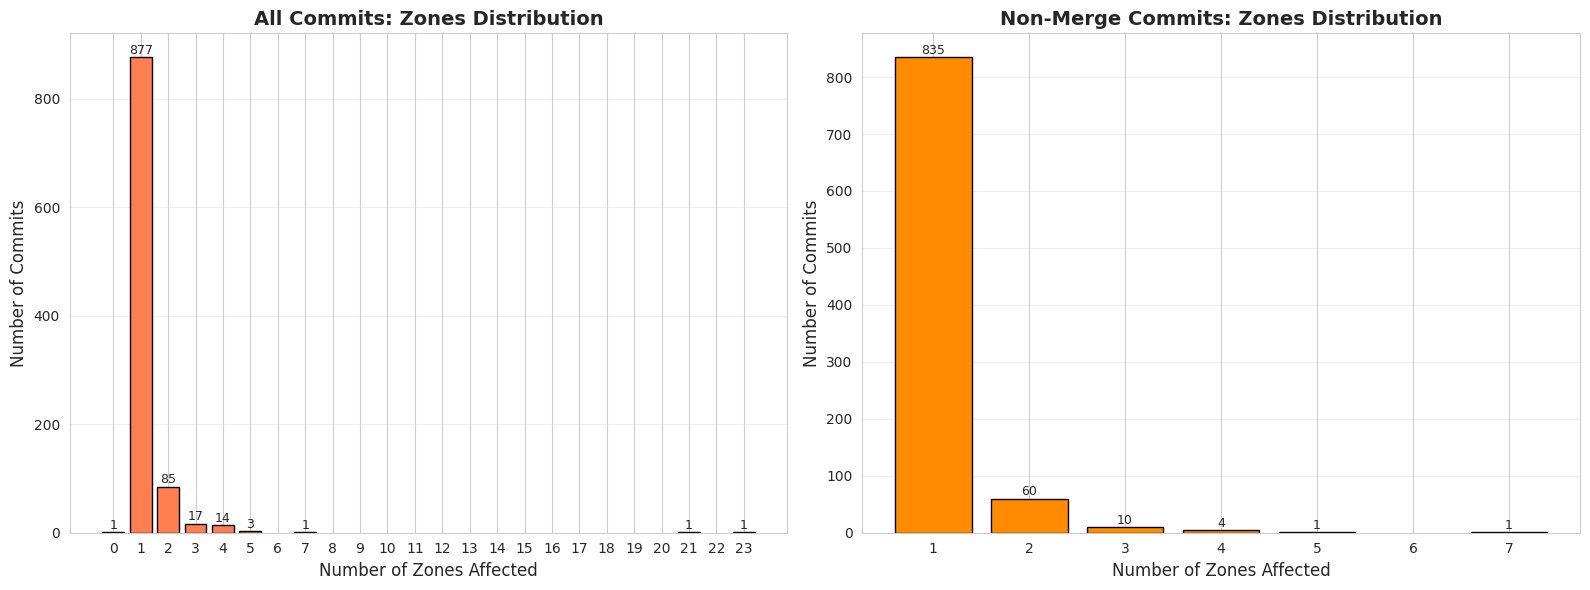

In [15]:
# Comparison: Distribution of number of zones (All vs Non-Merge)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All commits
num_zones_all = df['num_zones'].value_counts().sort_index()
axes[0].bar(num_zones_all.index, num_zones_all.values, color='coral', edgecolor='black')
axes[0].set_xlabel('Number of Zones Affected', fontsize=12)
axes[0].set_ylabel('Number of Commits', fontsize=12)
axes[0].set_title('All Commits: Zones Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(int(num_zones_all.index.min()), int(num_zones_all.index.max()) + 1))
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for x, y in zip(num_zones_all.index, num_zones_all.values):
    axes[0].text(x, y + 0.5, str(y), ha='center', va='bottom', fontsize=9)

# Non-merge commits
axes[1].bar(non_merge_zone_counts.index, non_merge_zone_counts.values, color='darkorange', edgecolor='black')
axes[1].set_xlabel('Number of Zones Affected', fontsize=12)
axes[1].set_ylabel('Number of Commits', fontsize=12)
axes[1].set_title('Non-Merge Commits: Zones Distribution', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(int(non_merge_zone_counts.index.min()), int(non_merge_zone_counts.index.max()) + 1))
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for x, y in zip(non_merge_zone_counts.index, non_merge_zone_counts.values):
    axes[1].text(x, y + 0.5, str(y), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Summary Statistics: Merge vs Non-Merge

Compare key statistics between merge and non-merge commits.

In [16]:
# Summary comparison
merge_commits = [c for c in commits if c['is_merge']]

print("=" * 60)
print("SUMMARY COMPARISON: MERGE vs NON-MERGE COMMITS")
print("=" * 60)
print(f"\nTotal commits: {len(commits)}")
print(f"  - Merge commits: {len(merge_commits)} ({len(merge_commits)/len(commits)*100:.1f}%)")
print(f"  - Non-merge commits: {len(non_merge_commits)} ({len(non_merge_commits)/len(commits)*100:.1f}%)")

print(f"\n{'Metric':<40} {'All Commits':<15} {'Non-Merge':<15} {'Merge Only':<15}")
print("-" * 85)

# Average zones per commit
avg_zones_all = sum(c['num_zones'] for c in commits) / len(commits)
avg_zones_non_merge = sum(c['num_zones'] for c in non_merge_commits) / len(non_merge_commits)
avg_zones_merge = sum(c['num_zones'] for c in merge_commits) / len(merge_commits) if merge_commits else 0

print(f"{'Average zones per commit':<40} {avg_zones_all:<15.2f} {avg_zones_non_merge:<15.2f} {avg_zones_merge:<15.2f}")

# Max zones
max_zones_all = max(c['num_zones'] for c in commits)
max_zones_non_merge = max(c['num_zones'] for c in non_merge_commits)
max_zones_merge = max(c['num_zones'] for c in merge_commits) if merge_commits else 0

print(f"{'Max zones in a single commit':<40} {max_zones_all:<15} {max_zones_non_merge:<15} {max_zones_merge:<15}")

# Commits with multiple zones
multi_zone_all = sum(1 for c in commits if c['num_zones'] > 1)
multi_zone_non_merge = sum(1 for c in non_merge_commits if c['num_zones'] > 1)
multi_zone_merge = sum(1 for c in merge_commits if c['num_zones'] > 1)

print(f"{'Commits with multiple zones':<40} {multi_zone_all:<15} {multi_zone_non_merge:<15} {multi_zone_merge:<15}")
print(f"{'% commits with multiple zones':<40} {multi_zone_all/len(commits)*100:<15.1f} {multi_zone_non_merge/len(non_merge_commits)*100:<15.1f} {multi_zone_merge/len(merge_commits)*100 if merge_commits else 0:<15.1f}")

print("\n" + "=" * 60)

SUMMARY COMPARISON: MERGE vs NON-MERGE COMMITS

Total commits: 1000
  - Merge commits: 89 (8.9%)
  - Non-merge commits: 911 (91.1%)

Metric                                   All Commits     Non-Merge       Merge Only     
-------------------------------------------------------------------------------------
Average zones per commit                 1.22            1.11            2.33           
Max zones in a single commit             23              7               23             
Commits with multiple zones              122             76              46             
% commits with multiple zones            12.2            8.3             51.7           

